<a href="https://colab.research.google.com/github/Alphver/Group5_ml_coursework2/blob/master/Group5_Coursework2_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the project of implementing neural network to build a dog breed classifier. To correctly run this program, first you need to upload this three file: annotation.tar, images.tar, list.tar in this url:http://vision.stanford.edu/aditya86/ImageNetDogs/  to you google drive then you can run it step by step.

Mount google drive to colab, need certification

In [0]:
import os
import tarfile
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Extract images from compressed files.

In [0]:
import zipfile
def extract(tar_path, target_path):
    tar = tarfile.open(tar_path, "r")
    file_names = tar.getnames()
    for file_name in file_names:
        tar.extract(file_name, target_path)
    tar.close()


In [0]:
extract("/content/drive/My Drive/images.tar","/content/dataset")

Define path of the images and cropped images

In [0]:
import scipy.io
import scipy.io
import numpy as np
import pandas as pd

from tensorflow import keras

import os
import shutil
original_dataset_dir="/content/dataset/Images"
base_dir="/content/dataset/Images_New_Path"
cropped_dir="/content/dataset/Cropped_Images"
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
if not os.path.exists(cropped_dir):
    os.mkdir(cropped_dir)

Using pip to install spilit folder package, it helps to split train/validation/test set

In [0]:
!pip install split-folders

split folder in train/validation/test set

In [0]:
import split_folders
split_folders.ratio(original_dataset_dir, output=base_dir, seed=1337, ratio=(.8, .1, .1)) # default values
split_folders.ratio(original_dataset_dir, output=cropped_dir, seed=1337, ratio=(.8, .1, .1)) # default values

Copying files: 20580 files [00:04, 4597.86 files/s]
Copying files: 20580 files [00:04, 4398.39 files/s]


Crop image

In [0]:
import sys
import tarfile
from six.moves import cPickle as pickle
from scipy import ndimage, io, misc
from xml.dom import minidom

In [0]:
last_percent_reported = None
data_root = '.'
num_classes = 120
image_size = 224
num_channels = 3
np.random.seed(133)

In [0]:
extract("/content/drive/My Drive/annotation.tar","/content/Annotation")

In [0]:
import imageio
import numpy
from PIL import Image
def load_breed(folder):
    """
    Load the data for a single breed label.
    """
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size,num_channels), dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = folder+'/'+image
        try:
            
            image_data = imageio.imread(image_file)
            
            annon_file = 'Annotation'+'/'+'Annotation' + '/' + folder.split('/')[-1] + '/' + image.split('.')[0]
            annon_xml = minidom.parse(annon_file)
            xmin = int(annon_xml.getElementsByTagName('xmin')[0].firstChild.nodeValue)
            ymin = int(annon_xml.getElementsByTagName('ymin')[0].firstChild.nodeValue)
            xmax = int(annon_xml.getElementsByTagName('xmax')[0].firstChild.nodeValue)
            ymax = int(annon_xml.getElementsByTagName('ymax')[0].firstChild.nodeValue)
            
            new_image_data = image_data[ymin:ymax,xmin:xmax,:]
            img = Image.fromarray(new_image_data)
            img = img.resize(size = (image_size, image_size))
            img.save(folder + '/' + image)
            #new_image_data = misc.imresize(new_image_data, (image_size, image_size))
            #imageio.imwrite(folder + '/' + image, image)
            dataset[num_images, :, :, :] = img
            num_images = num_images + 1
        except IOError as e:
            print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')

    dataset = dataset[0:num_images, :, :, :]

    print('Full dataset tensor:', dataset.shape)
    return dataset

In [0]:
def maybe_pickle(data_folders, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_breed(folder)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
  
    return dataset_names

In [0]:
images_folders=os.listdir('/content/dataset/Cropped_Images/train')
images_folders=['/content/dataset/Cropped_Images/train'+'/'+d for d in images_folders]

In [0]:
images_datasets = maybe_pickle(images_folders, force=True)


Define images and cropped images directory

In [0]:
#original images
train_dir=os.path.join(base_dir,"train")
validation_dir=os.path.join(base_dir,"val")
test_dir=os.path.join(base_dir,"test")
#cropped images
cropped_train_dir=os.path.join(cropped_dir,"train")
cropped_validation_dir=os.path.join(cropped_dir,"val")
cropped_test_dir=os.path.join(cropped_dir,"test")

Preprocessing of images

In [0]:
from keras import layers
from keras import models
import PIL

Using TensorFlow backend.


In [0]:
#preprocessing of images, create a generator with original images
from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)
evaluate_datagen=ImageDataGenerator(rescale=1./255)

#WAY 1
train_generator=train_datagen.flow_from_directory(train_dir,batch_size=20,target_size=(150,150),class_mode='sparse')
validation_generator=test_datagen.flow_from_directory(validation_dir,batch_size=20,target_size=(150,150),class_mode='sparse')
evaluate_generator=evaluate_datagen.flow_from_directory(test_dir,batch_size=20,target_size=(150,150),class_mode='sparse')

for i ,j in train_generator:
    print("data batch shape:",i.shape)
    print("label batch shape",j.shape)
    break

Found 16418 images belonging to 120 classes.
Found 2009 images belonging to 120 classes.
Found 2153 images belonging to 120 classes.
data batch shape: (20, 150, 150, 3)
label batch shape (20,)


In [0]:
#preprocessing of cropped images, create a generator with cropped images
from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)
evaluate_datagen=ImageDataGenerator(rescale=1./255)

#WAY 1
cropped_train_generator=train_datagen.flow_from_directory(cropped_train_dir,batch_size=20,target_size=(150,150),class_mode='sparse')
cropped_validation_generator=test_datagen.flow_from_directory(cropped_validation_dir,batch_size=20,target_size=(150,150),class_mode='sparse')
cropped_evaluate_generator=evaluate_datagen.flow_from_directory(cropped_test_dir,batch_size=20,target_size=(150,150),class_mode='sparse')

for i ,j in cropped_train_generator:
    print("data batch shape:",i.shape)
    print("label batch shape",j.shape)
    break

Found 16418 images belonging to 120 classes.
Found 2009 images belonging to 120 classes.
Found 2153 images belonging to 120 classes.
data batch shape: (20, 150, 150, 3)
label batch shape (20,)


Xception model

In [0]:

from tensorflow import keras
model=keras.applications.xception.Xception(include_top=True, weights='imagenet',
                                    input_tensor=None, input_shape=None,
                                    pooling=None, classes=1000)
model.summary()



Fit Xception model using original images.

In [0]:
#fit_model
from keras import optimizers
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
model.compile(loss = "sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(), metrics = ["accuracy"])
history = model.fit_generator(train_generator,epochs=20,validation_data=validation_generator,steps_per_epoch=300,validation_steps=50,callbacks=early_stopping_cb,)
score,acc = model.evaluate_generator(evaluate_generator,steps=108)
print("Score is ", score)
print("Accuracy is ",acc)


Fit Xception model using cropped images.

In [0]:
#fit_model
from keras import optimizers
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
model.compile(loss = "sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(), metrics = ["accuracy"])
history = model.fit_generator(cropped_train_generator,epochs=20,validation_data=cropped_validation_generator,steps_per_epoch=300,validation_steps=30)
score,acc = model.evaluate_generator(cropped_evaluate_generator,steps=108)
print("Score is ", score)
print("Accuracy is ",acc)

72/72 [==============================] - 30s 418ms/step - loss: 1.1370 - accuracy: 0.6910 - val_loss: 1.3738 - val_accuracy: 0.6500
Score is  1.3170934915542603
Accuracy is  0.658151388168335


The self-created model

In [0]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
model = keras.models.Sequential([                                
    keras.layers.Conv2D(64,(3,3),activation="relu",input_shape=(150,150,3)),
    keras.layers.MaxPool2D(2,2), #(36,36,64)
    keras.layers.Conv2D(128,(3,3),activation="relu"), #(34,34,128)
    keras.layers.MaxPool2D(2,2), #(17,17,128)
    keras.layers.Conv2D(256,(3,3),activation="relu"), #(15,15,128)
    keras.layers.MaxPool2D(2,2), #(7,7,128)
    #keras.layers.Flatten() #7*7*128=6272
    keras.layers.GlobalAveragePooling2D(data_format=None),
    keras.layers.Dense(120,activation="softmax")  
])
model.summary()

In [0]:
#fit model
model.compile(loss = "sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(), metrics = ["accuracy"])
history = model.fit_generator(train_generator,epochs=30,validation_data=validation_generator,callbacks=early_stopping_cb,steps_per_epoch=372,validation_steps=50)
score,acc = model.evaluate_generator(evaluate_generator,steps=108)
print("Score is ", score)
print("Accuracy is ",acc)

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','val'], loc='upper left')
plt.show()

Solve the problem of overfitting

1.Data Augmentation+dropout

In [0]:
#Augmemtation for original images
from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1./255,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode="nearest")
test_datagen=ImageDataGenerator(rescale=1./255)
evaluate_datagen=ImageDataGenerator(rescale=1./255)

#WAY 1
train_generator=train_datagen.flow_from_directory(train_dir,batch_size=20,target_size=(150,150),class_mode='sparse')
validation_generator=test_datagen.flow_from_directory(validation_dir,batch_size=20,target_size=(150,150),class_mode='sparse')
evaluate_generator=evaluate_datagen.flow_from_directory(test_dir,batch_size=20,target_size=(150,150),class_mode='sparse')
for i ,j in train_generator:
    print("data batch shape:",i.shape)
    print("label batch shape",j.shape)
    break

In [0]:
#Augmentation for cropped images
from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1./255,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode="nearest")
test_datagen=ImageDataGenerator(rescale=1./255)
evaluate_datagen=ImageDataGenerator(rescale=1./255)
#WAY 1
cropped_train_generator=train_datagen.flow_from_directory(cropped_train_dir,batch_size=20,target_size=(299,299),class_mode='sparse')
cropped_validation_generator=test_datagen.flow_from_directory(cropped_validation_dir,batch_size=20,target_size=(299,299),class_mode='sparse')
cropped_evaluate_generator=evaluate_datagen.flow_from_directory(cropped_test_dir,batch_size=20,target_size=(150,150),class_mode='sparse')
for i ,j in cropped_train_generator:
    print("data batch shape:",i.shape)
    print("label batch shape",j.shape)
    break

In [0]:
#Xception model
from tensorflow import keras
model=keras.applications.xception.Xception(include_top=True, weights='imagenet',
                                    input_tensor=None, input_shape=None,
                                    pooling=None, classes=1000)
model.summary()

In [0]:
#Fit the model using original images
from keras import optimizers
model.compile(loss = "sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(), metrics = ["accuracy"])
history = model.fit_generator(train_generator,epochs=50,validation_data=validation_generator,steps_per_epoch=514,validation_steps=50,callbacks=[reduce_lr])
score,acc = model.evaluate_generator(evaluate_generator,steps=108)
print("Score is ", score)
print("Accuracy is ",acc)

In [0]:
#Fit the model using cropped images
from keras import optimizers
reduce_lr=keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
model.compile(loss = "sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(), metrics = ["accuracy"])
history = model.fit_generator(cropped_train_generator,epochs=30,validation_data=validation_generator,steps_per_epoch=514,validation_steps=30,callbacks=[reduce_lr])
score,acc = model.evaluate_generator(cropped_evaluate_generator,steps=108)
print("Score is ", score)
print("Accuracy is ",acc)

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','val'], loc='upper left')
plt.show()

2.Feature extraction

1.The features learned by the convolution layer are more general 
2.The dense connection layer does not contain the physical location of the object
3.The layer near the bottom extracts local, highly versatile feature maps
4.More abstract concepts extracted from the layer near the top

1)Feature extraction using Xception+dropout()

In [0]:
# the model for target_size=(150,150)
from tensorflow import keras
conv=keras.applications.xception.Xception(include_top=False, weights='imagenet',
                                    input_shape=(150,150,3)) # "Include_top=False" means it doesn't use dense layer

conv.summary()

In [0]:
# the model for target_size=(299,299)
from tensorflow import keras
conv=keras.applications.xception.Xception(include_top=False, weights='imagenet',
                                    input_shape=(299,299,3)) # "Include_top=False" means it doesn't use dense layer

conv.summary()

We cannot use data augmentation here because each image only enter the convolution layer once, 

In [0]:
# the feature selection for target_size=(150,150)
from keras.preprocessing.image import ImageDataGenerator
data_gen=ImageDataGenerator(rescale=1./255)
batch_size=20
def exact_features(directory,sample_count):
    features=np.zeros(shape=(sample_count,5,5,2048)) # last layer of xception is (5,5,2048)
    labels=np.zeros(shape=(sample_count))
    generator=data_gen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='sparse'
    )
    i=0
    for input_batch,labels_batch in generator:
        features_batch=conv.predict(input_batch)
        features[i*batch_size:(i+1)*batch_size]=features_batch
        labels[i*batch_size:(i+1)*batch_size]=labels_batch
        i+=1
        if i*batch_size>=sample_count:
            break
    return features,labels

In [0]:
# the feature selection for target_size=(299,299)
from keras.preprocessing.image import ImageDataGenerator
data_gen=ImageDataGenerator(rescale=1./255)
batch_size=20
def exact_features(directory,sample_count):
    features=np.zeros(shape=(sample_count,10,10,2048)) # last layer of xception is (5,5,2048)
    labels=np.zeros(shape=(sample_count))
    generator=data_gen.flow_from_directory(
        directory,
        target_size=(299,299),
        batch_size=batch_size,
        class_mode='sparse'
    )
    i=0
    for input_batch,labels_batch in generator:
        features_batch=conv.predict(input_batch)
        features[i*batch_size:(i+1)*batch_size]=features_batch
        labels[i*batch_size:(i+1)*batch_size]=labels_batch
        i+=1
        if i*batch_size>=sample_count:
            break
    return features,labels

In [0]:
# the feature selection for target_size=(150,150)
train_features,train_labels=exact_features(train_dir,16418)
validation_features,validation_labels=exact_features(validation_dir,2009)
train_features=np.reshape(train_features,(16418,5*5*2048))
validation_features=np.reshape(validation_features,(2009,5*5*2048))

In [0]:
# the feature selection for target_size=(299,299)
train_features,train_labels=exact_features(train_dir,12000)
validation_features,validation_labels=exact_features(validation_dir,8580)
train_features=np.reshape(train_features,(12000,10*10*2048))
validation_features=np.reshape(validation_features,(8580,10*10*2048))

Add Dense

In [0]:
from keras import layers
from keras import models
import PIL


In [0]:
model = keras.models.Sequential([                                
    keras.layers.Dense(256,activation="relu",input_dim=5*5*2048),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(120, activation="softmax")
])
model.summary()

In [0]:
# fit model for original images
from keras import optimizers
reduce_lr=keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
model.compile(loss = "sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(), metrics = ["accuracy"])
history = model.fit(train_features,train_labels,epochs=30,validation_data=(validation_features,validation_labels),callbacks=[reduce_lr])
score,acc = model.evaluate_generator(evaluate_generator,steps=108)
print("Score is ", score)
print("Accuracy is ",acc)

In [0]:
# fit model for cropped images--RAM blew up
from tensorflow import keras
from keras import optimizers

reduce_lr=keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
model.compile(loss = "sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(), metrics = ["accuracy"])
history = model.fit(train_features,train_labels,epochs=30,validation_data=(validation_features,validation_labels),callbacks=[reduce_lr])
score,acc = model.evaluate_generator(cropped_evaluate_generator,steps=108)
print("Score is ", score)
print("Accuracy is ",acc)

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','val'], loc='upper left')
plt.show()

2)Change model to inceptionResnet with the deapest layers
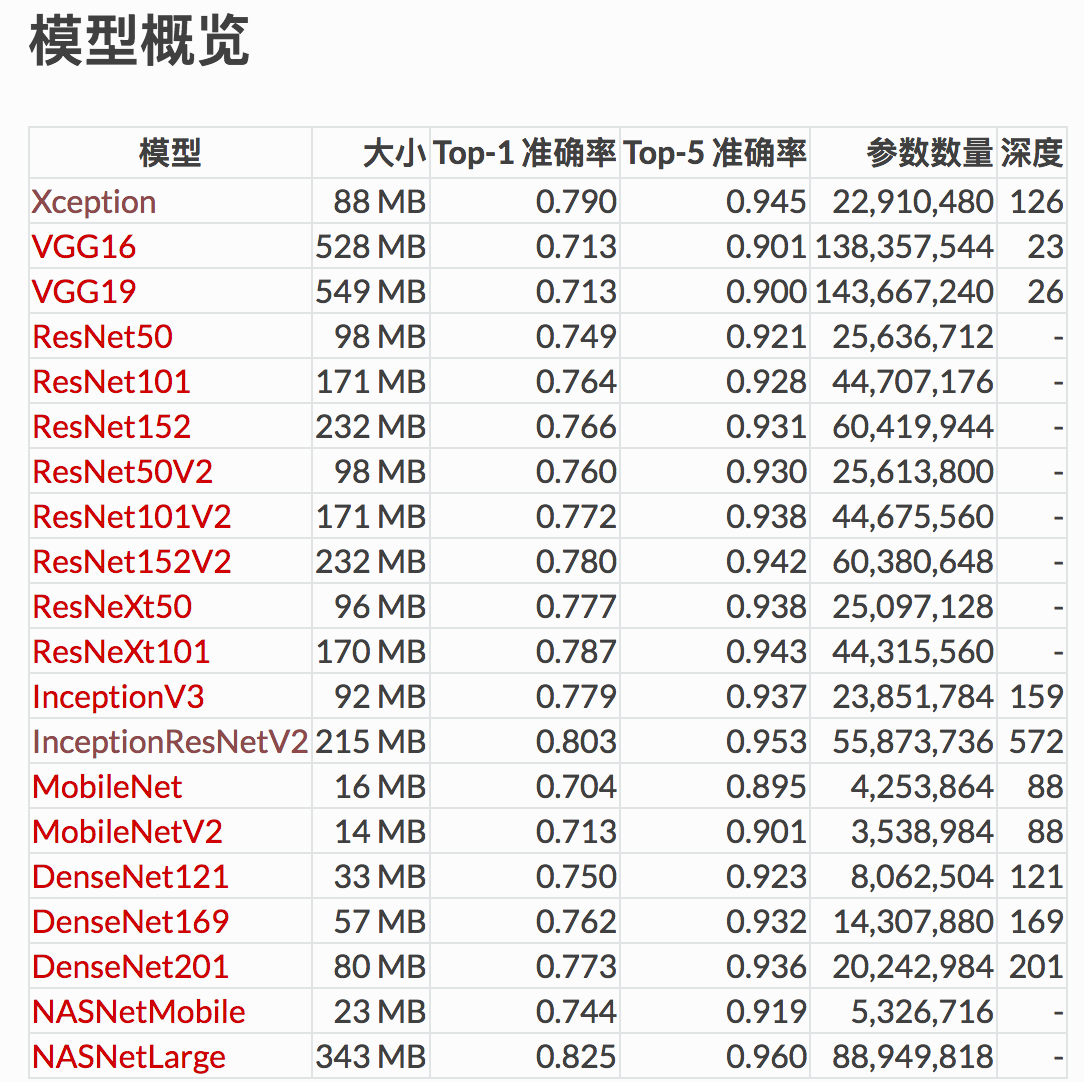

In [0]:
from tensorflow import keras

conv2=keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet',input_shape=(299,299,3))

conv2.summary()

In [0]:
from keras.preprocessing.image import ImageDataGenerator
data_gen=ImageDataGenerator(rescale=1./255)
batch_size=20
def exact_features(directory,sample_count):
    features=np.zeros(shape=(sample_count,3,3,1536)) # last layer of xception is (5,5,2048)
    labels=np.zeros(shape=(sample_count))
    generator=data_gen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='sparse'
    )
    i=0
    for input_batch,labels_batch in generator:
        features_batch=conv2.predict(input_batch)
        features[i*batch_size:(i+1)*batch_size]=features_batch
        labels[i*batch_size:(i+1)*batch_size]=labels_batch
        i+=1
        if i*batch_size>=sample_count:
            break
    return features,labels

In [0]:
train_features,train_labels=exact_features(train_dir,16418)
validation_features,validation_labels=exact_features(validation_dir,2009)
train_features=np.reshape(train_features,(16418,3*3*1536))
validation_features=np.reshape(validation_features,(2009,3*3*1536))

In [0]:
model = keras.models.Sequential([                                
    keras.layers.Dense(256,activation="relu",input_dim=3*3*1536),
    #keras.layers.Dense(128, activation="relu"),
    #keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(120, activation="softmax")
])
model.summary()

In [0]:
from keras import optimizers
reduce_lr=keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
model.compile(loss = "sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(), metrics = ["accuracy"])
history = model.fit(train_features,train_labels,epochs=50,validation_data=(validation_features,validation_labels),callbacks=[reduce_lr])
score,acc = model.evaluate_generator(evaluate_generator,steps=108)
print("Score is ", score)
print("Accuracy is ",acc)

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','val'], loc='upper left')
plt.show()

Data augmentation

In [0]:
#for original images
from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1./255,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode="nearest")
test_datagen=ImageDataGenerator(rescale=1./255)
evaluate_datagen=ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_directory(train_dir,target_size=(150,150),batch_size=20,class_mode="sparse")
validation_generator=test_datagen.flow_from_directory(validation_dir,target_size=(150,150),batch_size=20,class_mode="sparse")
evaluate_generator=evaluate_datagen.flow_from_directory(test_dir,target_size=(150,150),batch_size=20,class_mode="sparse")

In [0]:
#after cropped
from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1./255,rotation_range=40,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode="nearest")
test_datagen=ImageDataGenerator(rescale=1./255)
evaluate_datagen=ImageDataGenerator(rescale=1./255)

cropped_train_generator=train_datagen.flow_from_directory(cropped_train_dir,target_size=(299,299),batch_size=20,class_mode="sparse")
cropped_validation_generator=test_datagen.flow_from_directory(cropped_validation_dir,target_size=(299,299),batch_size=20,class_mode="sparse")
cropped_evaluate_generator=evaluate_datagen.flow_from_directory(cropped_test_dir,target_size=(299,299),batch_size=20,class_mode="sparse")

In [0]:
#Conv is definited before- Xception
conv.trainable=False

In [0]:
model = keras.models.Sequential([        
    conv,   
    keras.layers.Flatten(),                     
    keras.layers.Dense(256,activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(120, activation="softmax")
])
model.summary()

In [0]:
#for original images
from keras import optimizers
reduce_lr=keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
model.compile(loss = "sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(), metrics = ["accuracy"])
history = model.fit_generator(train_generator,epochs=30,validation_data=validation_generator,steps_per_epoch=514,validation_steps=30,callbacks=[reduce_lr])
score,acc = model.evaluate_generator(evaluate_generator,steps=108)
print("Score is ", score)
print("Accuracy is ",acc)

In [0]:
#after cropped
from keras import optimizers
reduce_lr=keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
model.compile(loss = "sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(), metrics = ["accuracy"])
history = model.fit_generator(train_generator,epochs=30,validation_data=validation_generator,steps_per_epoch=514,validation_steps=30,callbacks=[reduce_lr])
score,acc = model.evaluate_generator(cropped_evaluate_generator,steps=108)
print("Score is ", score)
print("Accuracy is ",acc)

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','val'], loc='upper left')
plt.show()

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [0]:
#conv2 is definited before--InceptionResnet
conv2.trainable=False
model = keras.models.Sequential([        
    conv2,   
    keras.layers.Flatten(),                     
    keras.layers.Dense(256,activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(120, activation="softmax")
])
model.summary()

In [0]:
# for original images
from keras import optimizers
reduce_lr=keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
model.compile(loss = "sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(), metrics = ["accuracy"])
history = model.fit_generator(train_generator,epochs=50,validation_data=validation_generator,steps_per_epoch=514,validation_steps=50,callbacks=[reduce_lr])
score,acc = model.evaluate_generator(evaluate_generator,steps=108)
print("Score is ", score)
print("Accuracy is ",acc)

In [0]:
#after cropped
from keras import optimizers
reduce_lr=keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
model.compile(loss = "sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(), metrics = ["accuracy"])
history = model.fit_generator(train_generator,epochs=30,validation_data=validation_generator,steps_per_epoch=514,validation_steps=30,callbacks=[reduce_lr])
score,acc = model.evaluate_generator(cropped_evaluate_generator,steps=108)
print("Score is ", score)
print("Accuracy is ",acc)

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','val'], loc='upper left')
plt.show()